## Problem 1

In [ ]:
# Demonstrate tensorflow dropout regularization
# from 11_deep_learning.ipynb from Geron's github
import tensorflow as tf
import numpy as np
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
learning_rate = 0.01


reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

#### 1. Explain lines 27-30.
```X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")```<br>
```y = tf.placeholder(tf.int64, shape=(None), name="y")``` <br>
```training = tf.placeholder_with_default(False, shape=(), name='training')```<br>
In line 27-28, x and y variable are being defined with ```tf.placeholder()```, with the data type of float32 and int64 for each. On line 30, ```tf.placeholder_with_default``` will return a default tensor when the input is not given. In this case unless otherwise specified, ```False``` will be returned. 
#### 2. Describe what the function tf.layers.dropout in line 33 does. Explain what is dropout rate, and the difference between X and X drop.
```X_drop = tf.layers.dropout(X, dropout_rate, training=training)``` <br>
This line will construct a dropout layer for regularization. The dropout rate is the fraction of inputs randomly excluded from each update cycle. Here,dropout rate is 50 percent so 50 percent of the weights are randomly excluded during each cycle. X is the input and X_drop is the results. 
#### 3. Please describe what line 35-42 is doing. For example, what structure is being constructed here, what is being defined among these lines, how many layer is defined, what is the activation function, and what information do you expect the output will contain?
```with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
     hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")```<br>
In this section, a neural network is being constructed with a fully-connected layer followed by a dropout layer, than again by a fully-connected layer and a dropout layer. Here, Rectifying linear units are used as activation function. Finally there is another fully-connected layer. In the final layer, there is no activation function specified, therefore it's a linear activation by default. There is a total of five layers. 

#### 4. At several points in this code (and other code) there is a statement using “with tf.name scope”. What is the purpose of this with statement?
The purpose of scoping is to enable tensorflow to share variable and operation names. For example, <br>
```with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)``` <br>
will create a variable ```correct``` under the scope ```"eval"```. This  is similar to the directory structure. 
  
#### 5. Explain lines 52-54.
```with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))```
The ```tf.nn.in_top_k``` will return a boolean that indicate whether the ground truth label is in the top K prediction. Here, 1 is specified for K so we're actually asking if the prediction is equal to the ground truth. The accuracy variable will store the average number of correct predictions. 


## Problem 2 

(1, 70, 120, 1)  


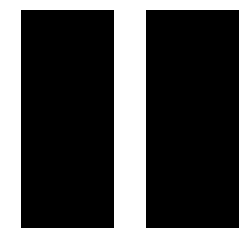

press return 11


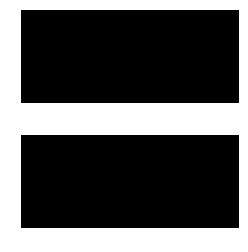

press return 22
Saving figure china_original


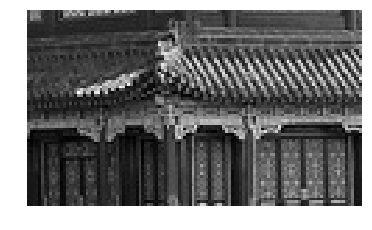

press return 33
Saving figure china_vertical


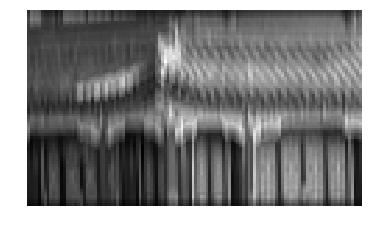

press return 44
Saving figure china_horizontal


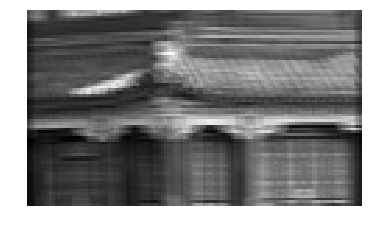

In [3]:
# tfconv1.py Demonstrate tensorflow convolution 1
# from 13_convolutional_network.ipynb from Geron's github
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
# Common imports
import numpy as np
import os
import tensorflow as tf
from sklearn.datasets import load_sample_image
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
# matplotlib inline


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
	# make sure the directories are made before saving!
    if tight_layout:
        plt.tight_layout()
    #plt.savefig(path, format='png', dpi=300)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")    


china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

print(images.shape," ")

# create two convolutive maps, a vertical bar and a horizontal bar

fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1   # make a column vector 
fmap[3, :, 0, 1] = 1   # make a row vector
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
input('press return 1')
plot_image(fmap[:, :, 0, 1])
plt.show()
input('press return 2')


reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()
input('press return 3')

plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()
input('press return 4')

plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

#### 2.1 Explain image = china[150:220, 130:250].
The following code shows that ```china[150:220, 130:250]``` will select certain pixels, namely from row 150 to 220 and column 130 to 250. The resulting patch is at the middle of the building. 

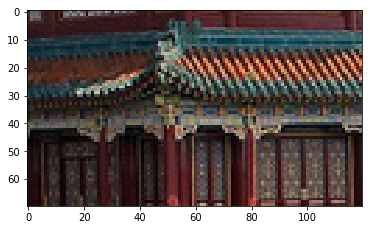

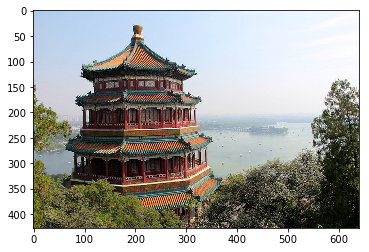

In [4]:
plt.imshow(china[150:220, 130:250])
plt.show()
plt.imshow(china)
plt.show()

#### 2.2 Explain what is going on in lines 71-72.
```with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})```<br>
The ```with tf.Session() as sess``` command will start a tensorflow session and release the resources when they are no longer needed. The ```.eval()``` method is equivalent to ```sess.run()```, which will both fetch the value of the tensor through the graph. In this case, it will return the results of the 2d convolution operation. 




In [ ]:
# tf.conv1_2.py
# from 13_convolutional_network.ipynb from Geron's github

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
# matplotlib inline

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1<
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
				
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

							


#### 2.3 What does the line Xreshaped = tf.reshape(X, shape = [−1, height,width, channels]) do?
This will reshape the input into [Mini batch size, height of image , width of image, number of channels] This will ensure all the inputs have the same dimension. 


#### 2.4 Explain what is set up in lines 48-53.
```conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,strides=conv2_stride, padding=conv2_pad,activation=tf.nn.relu, name="conv2")```<br>
In these lines, two convolution layers are being constructed. The first argument is the input being fed to the layer. The following arguments are for number of filters, size of the convolution kernel, stride size, padding method, activation function and the name of the layer. 
#### 2.5 Explain lines 56-57. What do the parameters of the pool command ksize and strides do? Why is pool3 reshaped? How does the pooling work?
``` pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])```<br>
    
#### 2.6 What is fc1?
```fc1``` is the name of the fully connected layer with 64 neurons. 
#### 2.7 What is Y proba in line 64?
```Y_proba = tf.nn.softmax(logits, name="Y_proba")```<br>
Here, ```Y_proba``` is the probability of the given input belonging to different labels. The results of softmax is a representation of categorical distribution over class labels. 
#### 2.8 Explain what is going on in lines 71-72.
```correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))```<br>
Similar to the previous problem, the tf.nn.in_top_k will return a boolean that indicate whether the ground truth label is in the top K prediction. Here, 1 is specified for K so we're actually asking if the prediction is equal to the ground truth. The accuracy variable will store the average number of correct predictions.


In [ ]:
# tfconv1_3.py
# from 13_convolutional_network.ipynb from Geron's github
# The following CNN is similar to the one defined above (tfconv1_2.py),
# except using stride 1 for the second convolutional layer (rather than 2),
# with 25% dropout after the second convolutional layer,
# 50% dropout after the fully connected layer, and trained
# using early stopping.
# It achieves around 99.2% accuracy on MNIST. This is not state of the art,
# but it is not bad.

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# The get_model_params() function gets the model's state (i.e., the value 
# of all the variables), and the restore_model_params() restores a previous 
# state. This is used to speed up early stopping: instead of storing the
# best model found so far to disk, we just save it to memory.
# At the end of training, we roll back to the best model found.

def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)


#  This implementation of Early Stopping works like this:
#   - every 100 training iterations, it evaluates the model on
#       the validation set,
#   - if the model performs better than the best model found so far,
#      then it saves the model to RAM,
#   - if there is no progress for 100 evaluations in a row,
#      then training is interrupted,
#   - after training, the code restores the best model found.

n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")    


    


#### 2.9 Explain how the dropout (lines 65-69) works.
```with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)```
The fully-connected layer receives pooling results as inputs. Outputs of the fully connected layer  are then sent to the dropout layer. The fc1_dropout_rate is the fraction of weights excluded from training in this step. In this case, the drop out rate is 50 percent, so 50 percent of the weights are turned off and the activations of these weights will not propagate to the later layers. This is to help prevent overfitting. 
#### 2.10 Explain what early stopping is, and how it is implemented in the program.
When we define the training operation, we will specify a default number of epochs. With the implementation of early stopping, we set a criteria that stop the training process when met. This could stop the training before the default number of epochs is reached, hence the name early stopping. In the case of this network, the early stopping criteria is having no improvement for 100 evaluations in a row. When that happens, the program will return the best model saved before stopping. 

## Problem 3.1
#### 3.1.a Describe how the principal components in PCA are chosen.
PCA transform observations into linearly uncorrelated principal components. The first principal component is chosen so that it accounts for as much variability in the data as possible. 
#### 3.1.b Please briefly describe what this function does, and why the results will be useful in implementing PCA.
The ```tf.svd()``` command will compute the singular value decompositions(SVD) of the input matrix. <br>
When performing PCA, we calculate the eigenvalues and eigenvectors of the covariance matrix. If our input data is X, then performing PCA will results in:
$$
XX^T = VDV^T
$$
Where $V$ is the matrix of eigenvectors and $D$ is the diagonal matrix with the eigenvalues $\lambda_i$. 
On the other hand, if we perform SVD on the same input data, we will get:
$$
X = U \Sigma V^T
$$
Where $U$ is the unitary matrix , $\Sigma$ is a rectangular diagonal matrix containing the singular values. We can therefore calculate the principal components by:
$$
XV = U \Sigma V^T V = U\Sigma
$$


## Problem 3.2

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Step 1: Minibatch Loss: 0.355809
Step 1000: Minibatch Loss: 0.045044
Step 2000: Minibatch Loss: 0.037010
Step 3000: Minibatch Loss: 0.032482
Step 4000: Minibatch Loss: 0.030803
Step 5000: Minibatch Loss: 0.031095
Step 6000: Minibatch Loss: 0.032077
Step 7000: Minibatch Loss: 0.031373
Step 8000: Minibatch Loss: 0.027257
Step 9000: Minibatch Loss: 0.026935
Step 10000: Minibatch Loss: 0.025731
Original Images


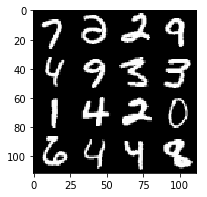

Reconstructed Images, hidden neurons = 16


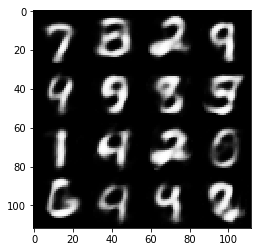

Reconstructed Images, hidden neurons = 8


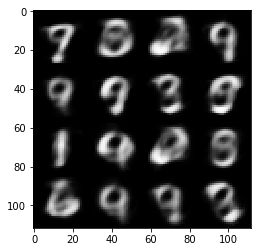

Reconstructed Images, hidden neurons = 4


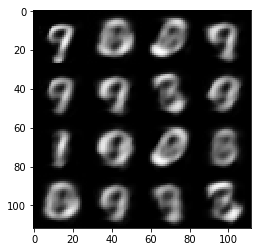

In [46]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 10000
batch_size = 128

display_step = 1000
examples_to_show = 3

# Network Parameters
num_hidden_1 = 16 # with 16 neurons 
num_hidden_2 = 8 # with 16 neurons 
num_hidden_3 = 4 # with 16 neurons 
num_input = 784 # MNIST data input (img shape: 28*28)





# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    'encoder_h2': tf.Variable(tf.random_normal([num_input, num_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_2, num_input])),
    'encoder_h3': tf.Variable(tf.random_normal([num_input, num_hidden_3])),
    'decoder_h3': tf.Variable(tf.random_normal([num_hidden_3, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([num_input])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
    'decoder_b3': tf.Variable(tf.random_normal([num_input])),

}

# Building 3 encoders and decoders with different number of neruons
def encoder1(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))   
    return layer_1


def decoder1(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

def encoder2(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h2']),
                                   biases['encoder_b2']))   
    return layer_1
def decoder2(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h2']),
                                   biases['decoder_b2'])) 
    return layer_1

def encoder3(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h3']),
                                   biases['encoder_b3']))   
    return layer_1
def decoder3(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h3']),
                                   biases['decoder_b3']))
    
    return layer_1
# Construct model
encoder_op1 = encoder1(X)
decoder_op1 = decoder1(encoder_op1)
encoder_op2 = encoder2(X)
decoder_op2 = decoder2(encoder_op2)
encoder_op3 = encoder3(X)
decoder_op3 = decoder3(encoder_op3)
# Prediction
y_pred1 = decoder_op1
y_pred2 = decoder_op2
y_pred3 = decoder_op3

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss1 = tf.reduce_mean(tf.pow(y_true - y_pred1, 2))
loss2 = tf.reduce_mean(tf.pow(y_true - y_pred2, 2))
loss3 = tf.reduce_mean(tf.pow(y_true - y_pred3, 2))

optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(loss1)
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(loss2)
optimizer3 = tf.train.AdamOptimizer(learning_rate).minimize(loss3)
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        
        _, l1 = sess.run([optimizer1, loss1], feed_dict={X: batch_x})
        _, l2 = sess.run([optimizer2, loss2], feed_dict={X: batch_x})
        _, l3 = sess.run([optimizer3, loss3], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l1))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon1 = np.empty((28 * n, 28 * n))
    canvas_recon2 = np.empty((28 * n, 28 * n))
    canvas_recon3 = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g1 = sess.run(decoder_op1, feed_dict={X: batch_x})
        g2 = sess.run(decoder_op2, feed_dict={X: batch_x})
        g3 = sess.run(decoder_op3, feed_dict={X: batch_x})
        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon1[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g1[j].reshape([28, 28])
            canvas_recon2[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g2[j].reshape([28, 28])
            canvas_recon3[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g3[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(3, 3))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images, hidden neurons = 16")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon1, origin="upper", cmap="gray")
    plt.show()
    
    print("Reconstructed Images, hidden neurons = 8")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon2, origin="upper", cmap="gray")
    plt.show()
    
    print("Reconstructed Images, hidden neurons = 4")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon3, origin="upper", cmap="gray")
    plt.show()

## Problem 3.3

#### Describe the similarity between PCA and an autoencoder.
Both PCA and autoencoder are unsupervised learning method for dimensional reduction. Both when a autoencoder converges, the weights of the neurons of the hidden layer will form a basis for the space spanned by the first n principal.  However, autoencoded introduces non-linearity while PCA is restricted to linear mapping. 


## Problem 3.4
#### What is the difference between a convolutional autoencoder and linear autoencoder?
The convolutional autoencoder uses convolution filters to extract features. These convolution filters make it possible for the autoencoder to handle high dimensional images because the number of parameters that required training to produce an activation map is the same. 
The linear autoencoder, on the other hand are fully-connected networks that discard the 2D image relationship of an image. During training, the image is transformed into a single vector. Linear autoencoders forces each feature to span across the entire visual field. 

## Problem 3.5
#### What similarities and differences are there between a denoising autoencoder and a variational autoencoder?
Both denoising autoencoder and variational autoencoder are variations of autoencoder. The objectives of these models are to recover the input distribution. They both follow structures similar to autoencoder. 

A variational autoencoder projects latent variables into the input space during decoding stage and learns how to sample from distribution to make the decoder a good generative model.

A denoising autoencoder corrupts the input by setting some of inputs to zero. The purpose of this is to prevent the identity function occurring in the network. By doing this, the autoencoder can therefore learn to extract the essential features that are useful for modeling the input distribution. 
The main difference between them is that DAE creates noises randomly at input level while VAE learns what noise to insert. VAEs are explicit generative models while DAEs are implicit generative models. 

## Problem 4

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Reconstructed Images at Epoch 0 


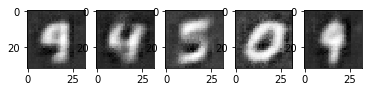

Reconstructed Images at Epoch: 3


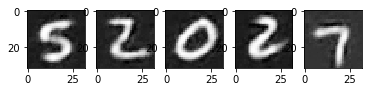

Reconstructed Images at Epoch: 5


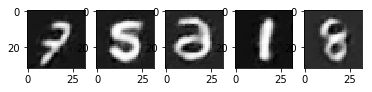

Input Images


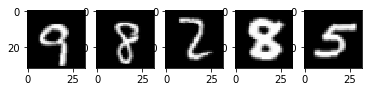

In [23]:
# An undercomplete autoencoder on MNIST dataset
from __future__ import division, print_function, absolute_import
import tensorflow.contrib.layers as lays

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from tensorflow.examples.tutorials.mnist import input_data

batch_size = 500  # Number of samples in each batch
epoch_num = 5     # Number of epochs to train the network
learning_rate = 0.001        # Learning rate

#Part 1 Reshape to 32 by 32
def resize_batch(imgs):
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs


def autoencoder(inputs):
    #32*32 -> 16*16*32 -> 8*8*16
    net = lays.conv2d(inputs, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME')
    
    net = lays.conv2d_transpose(net, 16, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d_transpose(net, 1, [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.tanh)
    return net

# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

ae_inputs = tf.placeholder(tf.float32, (None, 32, 32, 1))  # input to the network (MNIST images)
ae_outputs = autoencoder(ae_inputs)  # create the Autoencoder network

# calculate the loss and optimize the network
loss = tf.reduce_mean(tf.square(ae_outputs - ae_inputs))  # claculate the mean square error loss
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

# initialize the network
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num):  # epochs loop
        for batch_n in range(batch_per_ep):  # batches loop
            batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
            batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
            batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs: batch_img})
            #print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))
        if ep == 0:
            batch_img1, batch_label1 = mnist.test.next_batch(10)
            batch_img1 = resize_batch(batch_img1)
            recon_img1 = sess.run([ae_outputs], feed_dict={ae_inputs: batch_img1})[0]
        elif ep == 2:
            batch_img2, batch_label2 = mnist.test.next_batch(10)
            batch_img2 = resize_batch(batch_img2)
            recon_img2 = sess.run([ae_outputs], feed_dict={ae_inputs: batch_img2})[0]
        elif ep == 4:
            batch_img3, batch_label3 = mnist.test.next_batch(10)
            batch_img3 = resize_batch(batch_img3)
            recon_img3 = sess.run([ae_outputs], feed_dict={ae_inputs: batch_img3})[0]   
    
    plt.figure()
    print('Reconstructed Images at Epoch 0 ')
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(recon_img1[i, ..., 0], cmap='gray')
    plt.show()          
    
    plt.figure()
    print('Reconstructed Images at Epoch: 3')
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(recon_img2[i, ..., 0], cmap='gray')
    plt.show()          
    
    plt.figure()
    print('Reconstructed Images at Epoch: 5')
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(recon_img3[i, ..., 0], cmap='gray')
    plt.show()          
    
    
    plt.figure()
    print('Input Images')
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(batch_img[i, ..., 0], cmap='gray')
    plt.show()
    # test the trained network
    

    # plot the reconstructed images and their ground truths (inputs)
    
        
   